Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import cv2
import imghdr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

from PIL import Image

import os
import random

from tqdm.notebook import tqdm

Defining the variable for data_dir. With this code, variable data_dir is assigned to a string named 'data3'. 'data3' is the directory path of the image dataset that will be used in this model.

In [2]:
data_dir = 'data3'

Defining the variable for img_class. A list of strings as shown below is assigned to the variable img_class. This is to store the various image classes that can be found in the image dataset. There are a total of 13 classes.

In [3]:
img_class = ['analogue', 'digital', 'smart', 'headphone', 'tws', 'neckband', 'gaming', 'windows', 'mac', '2in1', 'loafers', 'sneakers', 'sports']

Looping through the images in each file. Resizes the images and assigning labels to each image based on the classes assigned in 'img_class'. Stores the newly resized images and its label into the 'data' list.

In [4]:
data = []

for classes in tqdm(img_class):
    directory = os.path.join(data_dir, classes)
    for image in os.listdir(directory):
        img_dir = os.path.join(directory, image)
        labels = img_class.index(classes)
        array = cv2.imread(img_dir)#, cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(array, (150,150))
        data.append([new_array, labels])

  0%|          | 0/13 [00:00<?, ?it/s]

Since the total number of images to be used in this model is only 904 images belonging to 13 different classes, albumentation is used to increase the total number to 27120

In [5]:
import albumentations as alb

augmentor = alb.Compose([alb.RandomGamma(p = 0.2), 
                         alb.RandomCrop(width = 150, height = 150), 
                         alb.RandomGamma(p = 0.2), 
                         alb.RandomBrightnessContrast(p = 0.2),
                         alb.RGBShift(p = 0.2),
                         alb.HorizontalFlip(p = 0.5), 
                         alb.VerticalFlip(p = 0.5)])

def augmentation(image):
    aug = augmentor(image=image)
    aug_img = aug['image']
    return aug_img

aug_data = []
for x in range(30):
    for new_array, labels in data:
        aug_img = augmentation(new_array)
        aug_data.append([aug_img, labels])

In [6]:
random.shuffle(aug_data)

X = []
y = []

for feature, labels in aug_data:
    X.append(feature)
    y.append(labels)

X = np.array(X)
y = np.array(y)

In [7]:
X = X/255
X = X.reshape(-1, 150, 150, 3)
X.shape

(27120, 150, 150, 3)

Using ImageDataGenerator to further improve on the data augmentation

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                             horizontal_flip = True,
                             vertical_flip = True,
                             rotation_range = 30,
                             zoom_range = 0.15,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             shear_range = 0.15,
                             fill_mode = "nearest")

testgen = ImageDataGenerator()

In [9]:
print(y)

[ 1  7  2 ...  2 10  1]


Splitting the dataset to train and test set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y)

In [13]:
print("x_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", X_test.shape)
print("y_test shape", y_test.shape)

x_train shape (18984, 150, 150, 3)
y_train shape (18984,)
x_test shape (8136, 150, 150, 3)
y_test shape (8136,)


In [14]:
nb = len(np.unique(y_train))
print(nb)

13


In [15]:
y_train = tf.keras.utils.to_categorical(y_train, nb)
y_test = tf.keras.utils.to_categorical(y_test, nb)

In [16]:
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

y_train shape (18984, 13)
y_test shape (8136, 13)


CNN model building

In [17]:
model = Sequential()

model.add(Conv2D(32, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(2, 2))

#model.add(Conv2D(64, (4,4), input_shape = (150, 150, 3), activation = 'relu', padding = 'same'))
#model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(nb, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        65600     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [19]:
model.compile(loss = 'categorical_crossentropy',
              metrics = ['accuracy'],
              optimizer = 'adam')

In [20]:
filepath= "model4.h5"

checkpoint = ModelCheckpoint(filepath,
                             monitor = 'val_accuracy',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_weights_only = False)

early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0, patience = 5,
                               verbose = 1,
                               restore_best_weights = True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00001)

callbacks_list = [
        checkpoint,
        early_stopping,
        learning_rate_reduction
    ]

In [21]:
hist = model.fit(datagen.flow(X_train, y_train, batch_size = 128),
                 validation_data = testgen.flow(X_test, y_test, batch_size = 128),
                 epochs = 100,
                 callbacks = callbacks_list)

Epoch 1/100
149/149 [==============================] - ETA: 0s - loss: 2.3888 - accuracy: 0.1681
Epoch 1: val_accuracy improved from -inf to 0.30678, saving model to model4.h5
149/149 [==============================] - 478s 3s/step - loss: 2.3888 - accuracy: 0.1681 - val_loss: 2.1016 - val_accuracy: 0.3068 - lr: 0.0010
Epoch 2/100
149/149 [==============================] - ETA: 0s - loss: 1.9564 - accuracy: 0.3313
Epoch 2: val_accuracy improved from 0.30678 to 0.39860, saving model to model4.h5
149/149 [==============================] - 375s 3s/step - loss: 1.9564 - accuracy: 0.3313 - val_loss: 1.9115 - val_accuracy: 0.3986 - lr: 0.0010
Epoch 3/100
149/149 [==============================] - ETA: 0s - loss: 1.5987 - accuracy: 0.4526
Epoch 3: val_accuracy improved from 0.39860 to 0.54794, saving model to model4.h5
149/149 [==============================] - 372s 2s/step - loss: 1.5987 - accuracy: 0.4526 - val_loss: 1.3165 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 4/100
149/149 [==========

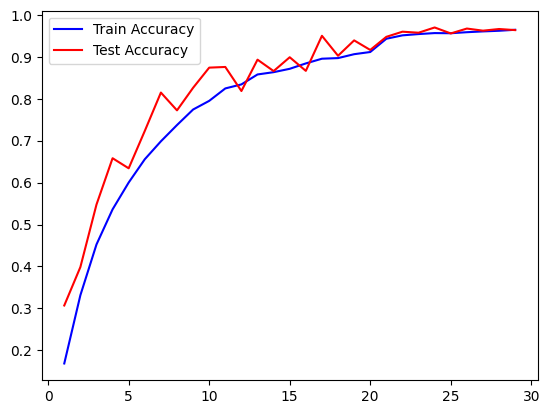

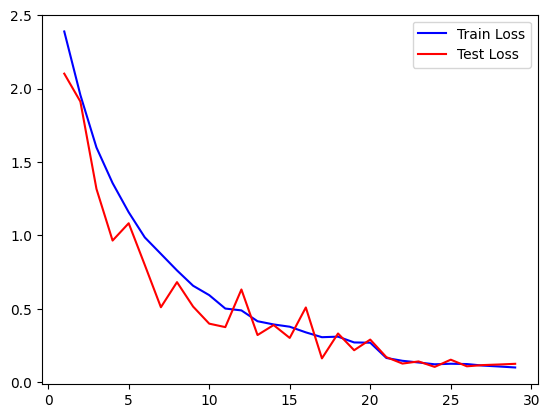

In [22]:
import matplotlib.pyplot as plt

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label = 'Train Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Test Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label = 'Train Loss')
plt.plot(epochs, val_loss, 'r', label = 'Test Loss')
plt.legend()
plt.show()